In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 09 - Attempt to Simplify Model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
import shap

In [6]:
from PyALE import ale

In [7]:
setup.plot_defaults()

## Import data

In [8]:
train_df = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_train.parquet'))

In [9]:
train_df.shape

(470858, 35)

In [9]:
train_samp_df = pd.read_parquet(Path(setup.temp_path) \
                                .joinpath('03_DATA_combined_base_train_samp.parquet')) 

In [10]:
predictor_features = pd.read_csv(Path(setup.temp_path) \
                                 .joinpath('01_REPORT_predictor_features.csv')) \
    ['feature'].tolist()

In [11]:
# Initial model
with open(Path(setup.temp_path).joinpath('02_MODEL_base_gc.pkl'), 'rb') as pi:
    base_model = pickle.load(pi)

In [12]:
perm_importance_df = pd.read_csv(Path(setup.temp_path).joinpath('02_DATA_importance_perturb.csv'))

In [13]:
perm_importance_df.head()

,features,importance,abs_importance
0,int_rate,0.003413,0.003413
1,term,0.001203,0.001203
2,loan_amnt,0.001010,0.001010
3,annual_inc,0.000983,0.000983
4,home_ownership__RENT,0.000759,0.000759


## Function to Get, Evaluate Models
Create models and see if we observe opposite interaction effects for ALE and Shapley for the interest rate and term interactions.  Fit a model, and evaluate SHAP and ALE values.  Fit on a full training data set, evaluate on a sample

In [73]:
def model_fit_eval(train_data, eval_data, features, fit_params, 
                   target_feature = 'target',
                   high_int_thresh = 20,
                  random_state=None):
    
    # Get the model
    model = GradientBoostingClassifier(n_estimators = fit_params['n_estimators'],
                                      random_state=random_state)
    model.set_params(**fit_params)
    model.fit(train_data[features], train_data[target_feature])
    
    # Get the ALE data
    this_ale = ale(X=eval_data[features], model=model, 
                   feature=['int_rate', 'term'], 
                   plot=False)
    
    # Look at ALE magnitudes for low vs. high interest rates
    this_ale['high_int'] = np.where(this_ale.index > high_int_thresh, 1, 0)
    this_ale_agg = this_ale.groupby(['high_int']).agg('mean')
    this_ale_direction = this_ale_agg.reset_index().corr().loc[60, 'high_int']
    
    # Get SHAP information
    explainer = shap.TreeExplainer(model, feature_names=features)
    shap_interactions =  explainer.shap_interaction_values(eval_data[features])
    
    # Get SHAP for only the interaction of interest
    term_ind = features.index('term')
    int_rate_ind = features.index('int_rate')
    this_shap = pd.concat([eval_data[['int_rate', 'term']].reset_index(),
                            pd.DataFrame({'shap': shap_interactions[:,term_ind, int_rate_ind]})],
                           axis=1)
    
    # Look at SHAP for low vs. high interest rates
    this_shap['high_int'] = np.where(this_shap['int_rate'] > high_int_thresh, 1, 0)
    this_shap_agg = this_shap.groupby(['term', 'high_int'])['shap'] \
        .agg('mean') \
        .reset_index() \
        .pivot(index='high_int', columns='term', values='shap')                   
    shap_direction = this_shap_agg.reset_index().corr().loc[60, 'high_int']
    
    # Return the summary
    if np.isnan([np.sign(shap_direction), np.sign(this_ale_direction)]).any():
        opposite_effects = False
    else:
        opposite_effects = np.sign(shap_direction) != np.sign(this_ale_direction)
    
    return opposite_effects, np.sign(this_ale_direction), this_ale, this_shap, model
    

#### Function to plot ALE, Shap from model_fit_eval returns

In [172]:
def comp_plot(ale_data, shap_data, color_categories = [36, 60],
             title = None):
    
    
    cmap = mpl.cm.coolwarm
    cnorm  = mpl.colors.Normalize(vmin=0, vmax= len(color_categories) -1)
    color_scalar_map = mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap)
    color_dict = {color_categories[i]: color_scalar_map.to_rgba(i) 
                  for i in range(0, len(color_categories))}
    
    fig, ax = plt.subplots(1, 2, figsize = (12,3), sharex = True)
    
    ale_data[[36, 60]].plot(legend=None, ax=ax[0], cmap=cmap)
    ax[0].set_title('ALE')
    ax[0].set_ylabel(None)

    for c in color_categories:
        shap_data[shap_data['term'] == c][['int_rate', 'shap']] \
            .plot(x='int_rate', y='shap', kind='scatter', ax=ax[1], color=color_dict[c],
                 label=c)
    ax[1].set_title('SHAP')  
    ax[1].set_ylabel(None)
    ax[1].legend(bbox_to_anchor=(1.2, 1.05))
    
    if title is not None:
        fig.suptitle(title)
    
    return fig

## Reduce the tree count
Use a much smaller tree count, see if the ALE/SHAP trend holds

In [17]:
fit_params_1 = base_model.get_params().copy()
fit_params_1['n_estimators'] = 10

In [18]:
opp_eff_1, ale_sign_1, ale_1, shap_1, _ = model_fit_eval(train_df, train_samp_df,
                                                         predictor_features,
                                                         fit_params_1)

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


In [19]:
opp_eff_1

True

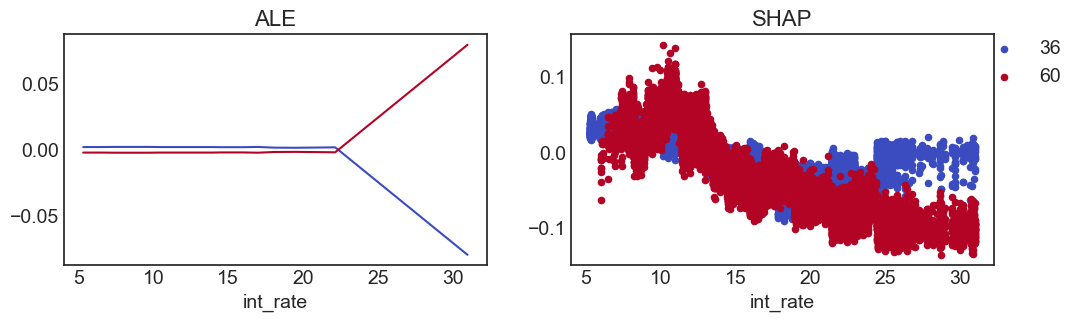

In [20]:
_ = comp_plot(ale_1, shap_1)

## Use fewer features

In [21]:
feat_list = perm_importance_df.sort_values('abs_importance', ascending=False)['features'].tolist()
feat_list = [f for f in feat_list if f not in ['int_rate', 'term']]
print(len(feat_list))

16


In [22]:
reduced_feature_list = feat_list[0:int(len(feat_list)/2)] + ['int_rate', 'term']
reduced_feature_list

['loan_amnt',
 'annual_inc',
 'home_ownership__RENT',
 'sec_app_fico_range_low',
 'num_actv_bc_tl',
 'open_acc',
 'revol_bal',
 'verification_status',
 'int_rate',
 'term']

In [23]:
opp_eff_2, ale_sign_2, ale_2, shap_2, _ = model_fit_eval(train_df, train_samp_df,
                                                         reduced_feature_list,
                                                         fit_params_1)

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


In [24]:
print(opp_eff_2)

True


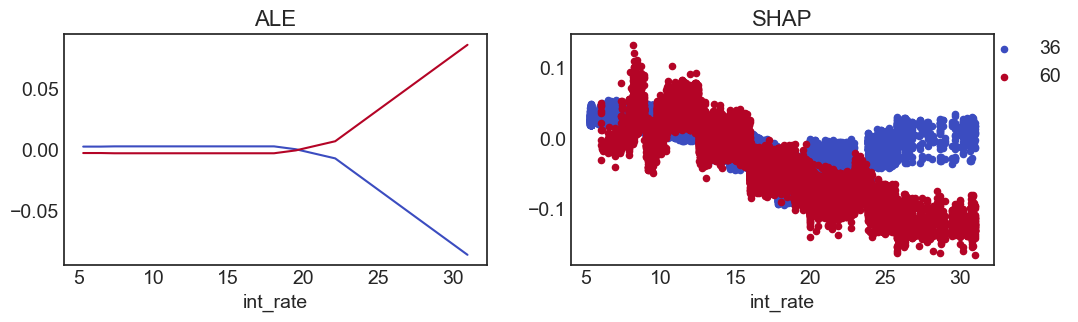

In [25]:
_ = comp_plot(ale_2, shap_2)

## Further Reduce Features

In [26]:
reduced_feature_list_2 = feat_list[0:int(len(feat_list)/4)] + ['int_rate', 'term']
reduced_feature_list_2

['loan_amnt',
 'annual_inc',
 'home_ownership__RENT',
 'sec_app_fico_range_low',
 'int_rate',
 'term']

In [27]:
opp_eff_3, ale_sign_3, ale_3, shap_3, _ = model_fit_eval(train_df, train_samp_df,
                                                         reduced_feature_list_2,
                                                         fit_params_1)

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


In [28]:
print(opp_eff_3)

True


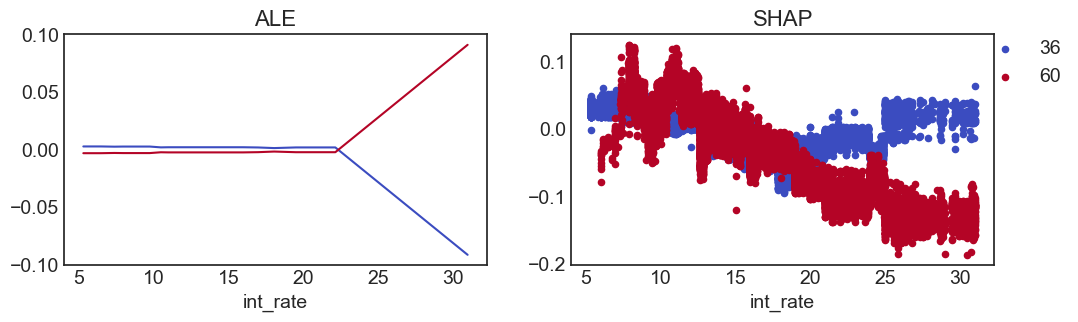

In [29]:
_ = comp_plot(ale_3, shap_3)

In [30]:
reduced_feature_list_3 = feat_list[0:2] + ['int_rate', 'term']
reduced_feature_list_3

['loan_amnt', 'annual_inc', 'int_rate', 'term']

In [31]:
opp_eff_4, ale_sign_4, ale_4, shap_4, _ = model_fit_eval(train_df, train_samp_df,
                                                         reduced_feature_list_3,
                                                         fit_params_1)

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


In [32]:
print(opp_eff_4)

True


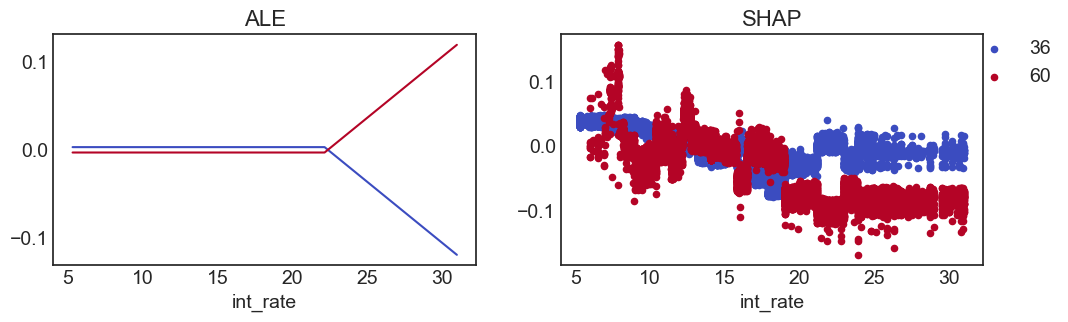

In [33]:
_ = comp_plot(ale_4, shap_4)

In [34]:
reduced_feature_list_4 = feat_list[0:1] + ['int_rate', 'term']
reduced_feature_list_4

['loan_amnt', 'int_rate', 'term']

In [35]:
opp_eff_5, ale_sign_5, ale_5, shap_5, _ = model_fit_eval(train_df, train_samp_df,
                                                         reduced_feature_list_3,
                                                         fit_params_1)

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


In [36]:
print(opp_eff_5)

True


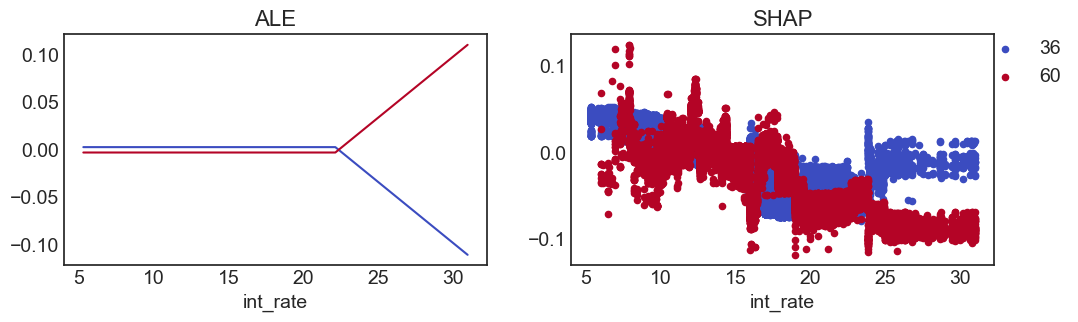

In [37]:
_ = comp_plot(ale_5, shap_5)

Now we have the same pattern for ALE and SHAP instead of inverse!  This model has interest rate, term, and loan amount only.  Try annual income instead of loan amount.

In [38]:
reduced_feature_list_5 = ['annual_inc', 'int_rate', 'term']

In [39]:
opp_eff_6, ale_sign_6, ale_6, shap_6, _ = model_fit_eval(train_df, train_samp_df,
                                                         reduced_feature_list_5,
                                                         fit_params_1)

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


In [40]:
print(opp_eff_6)

True


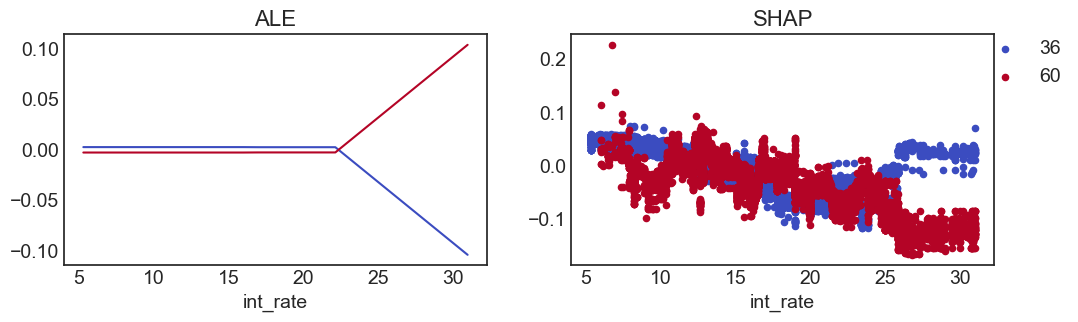

In [41]:
_ = comp_plot(ale_6, shap_6)

If we use annual income instead of loan amount, we recover the opposige ALE/SHAP pattern.  What about just interest rate and loan amount?

In [42]:
reduced_feature_list_6 = ['int_rate', 'term']

In [43]:
opp_eff_7, ale_sign_7, ale_7, shap_7, _ = model_fit_eval(train_df, train_samp_df,
                                                         reduced_feature_list_6,
                                                         fit_params_1)

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


In [44]:
print(opp_eff_7)

False


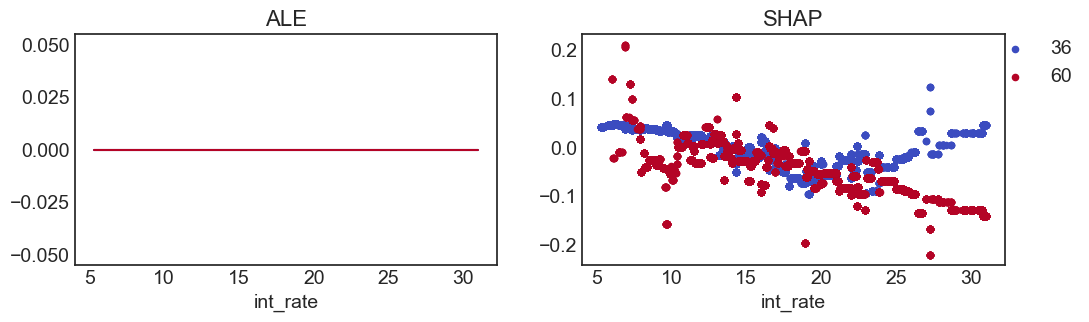

In [45]:
_ = comp_plot(ale_7, shap_7)

It appears we get no ALE signal from just the 2 feature model.  Use the 3 feature model and reduce complexity

## Fewer trees - interest rate, term, and loan amount models

In [46]:
def tree_trials(n, init_params = fit_params_1,
               features = reduced_feature_list_5):
    this_params = init_params.copy()
    this_params['n_estimators'] = n
    
    opp_eff_this, ale_sign_this, ale_this, shap_this, _ = \
        model_fit_eval(train_df, train_samp_df, features, this_params)
    
    return opp_eff_this, ale_sign_this

In [47]:
n_tree = [10, 9, 8, 6, 4, 3, 2, 1]

In [48]:
%%capture
res_tree_trials = [tree_trials(n) for n in n_tree]

In [49]:
print(res_tree_trials)

[(True, 1.0), (False, -1.0), (False, nan), (False, nan), (False, nan), (False, nan), (False, nan), (False, nan)]


It seems that fewer trees make this effect less likely.  Random state may be a factor

## Reduce max depth
Stay at 10 trees for now, although 9 or 8 may also work

In [50]:
def max_depth_trials(depth, init_params = fit_params_1,
                     features = reduced_feature_list_5):
    this_params = init_params.copy()
    this_params['max_depth'] = depth
    
    opp_eff_this, ale_sign_this, ale_this, shap_this, _ = \
        model_fit_eval(train_df, train_samp_df, features, this_params)
    
    return opp_eff_this, ale_sign_this

In [51]:
max_depth = [5, 4, 3, 2]

In [52]:
%%capture
max_depth_t = [max_depth_trials(d) for d in max_depth]

In [53]:
print(max_depth_t)

[(True, 1.0), (False, nan), (False, nan), (False, nan)]


## Check subsample

In [54]:
def subsample_trials(ss, init_params = fit_params_1,
                     features = reduced_feature_list_5):
    this_params = init_params.copy()
    this_params['subsample'] = ss
    
    opp_eff_this, ale_sign_this, ale_this, shap_this, _ = \
        model_fit_eval(train_df, train_samp_df, features, this_params)
    
    return opp_eff_this, ale_sign_this

In [55]:
subsample = [1, 0.8, 0.5, 0.3]

In [56]:
%%capture
subsample_t = [subsample_trials(d) for d in subsample]

In [57]:
print(subsample_t)

[(False, nan), (False, -1.0), (True, 1.0), (False, -1.0)]


##### Really interesting - subsample 1 differs.  Reran a couple times.  Values less than one may result in "stochastic gradient boosting"

## Get fairly simple model

In [95]:
fit_params_2 = fit_params_1.copy()
fit_params_2['max_depth'] = 5
fit_params_2['n_estimators'] = 10
fit_params_2['subsample']= 0.9

In [96]:
fit_params_2

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.2,
 'loss': 'log_loss',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 0.9,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [235]:
opp_eff_8, ale_sign_8, ale_8, shap_8, model_8 = \
    model_fit_eval(train_df, train_samp_df, reduced_feature_list_5,
                   fit_params_2,
                   random_state =42)

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


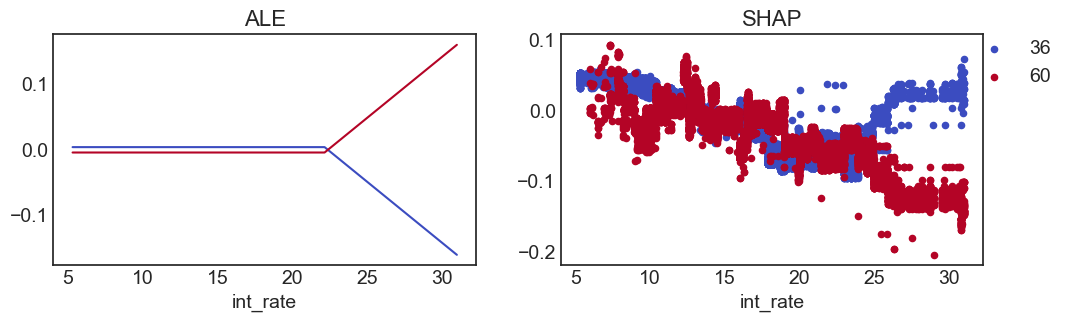

In [236]:
_ = comp_plot(ale_8, shap_8)

In [237]:
with open(Path(setup.temp_path).joinpath('09_MODEL_simplified.pkl'), 'wb') as po:
    pickle.dump(model_8, po)

In [238]:
model_8

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, min_samples_leaf=5,
                           min_samples_split=20, n_estimators=10,
                           subsample=0.9)

In [239]:
model_8.estimators_[0][0]

DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, min_samples_leaf=5,
                      min_samples_split=20,
                      random_state=RandomState(MT19937) at 0x110576C40)

## Plot Trees and Save Model

In [240]:
model_8.estimators_.shape

(10, 1)

In [241]:
for i in range(0, model_8.estimators_.shape[0]):
    fig, ax = plt.subplots(figsize=(100,20))
    _ = sk.tree.plot_tree(model_8.estimators_[i][0], 
                       feature_names=reduced_feature_list_5,  
                       filled=True, ax=ax, fontsize=14)
    fig.savefig(Path(setup.temp_path).joinpath('09_PLOT_tree_' + str(i) + '.png'),
                bbox_inches='tight')
    plt.close()

Observation: annual income node often at bottom, under term node only "60" side

X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


0


X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


1


X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


2


X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


3


X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


4


X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


5


X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


6


X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


7


X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


8


X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


9


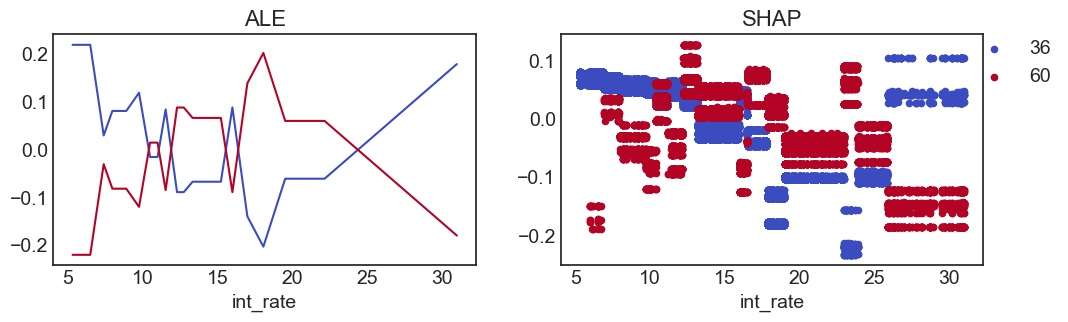

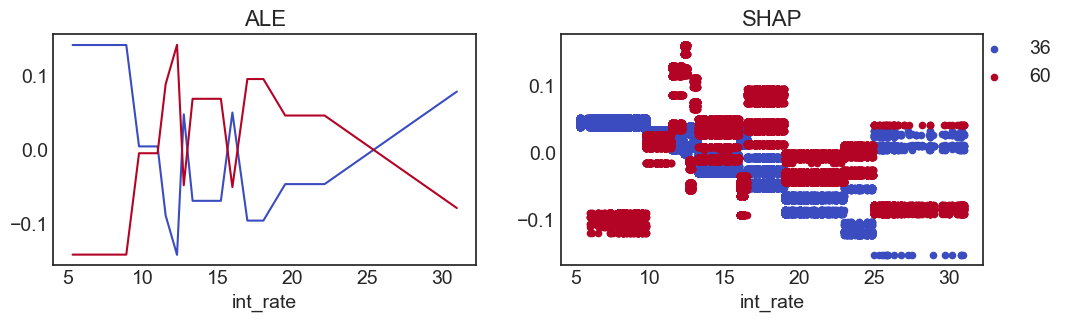

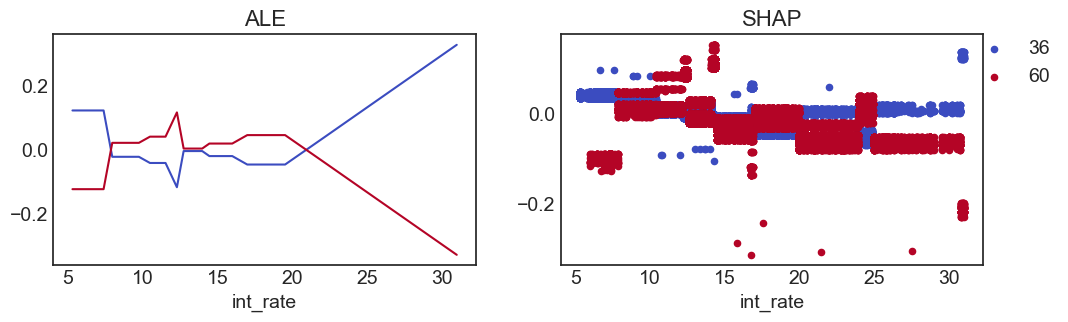

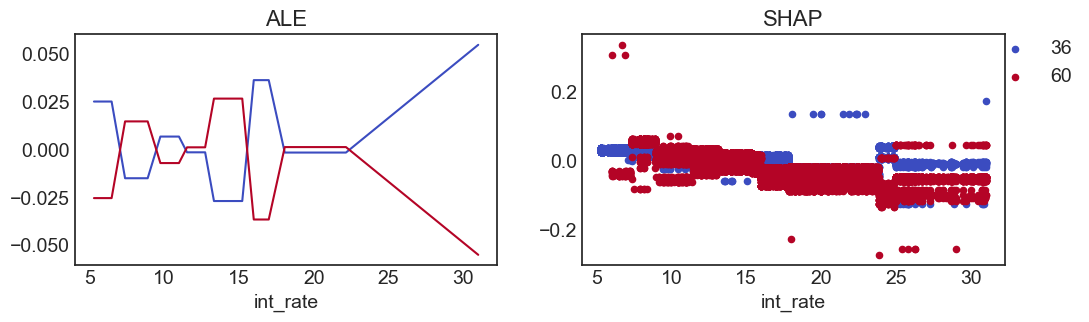

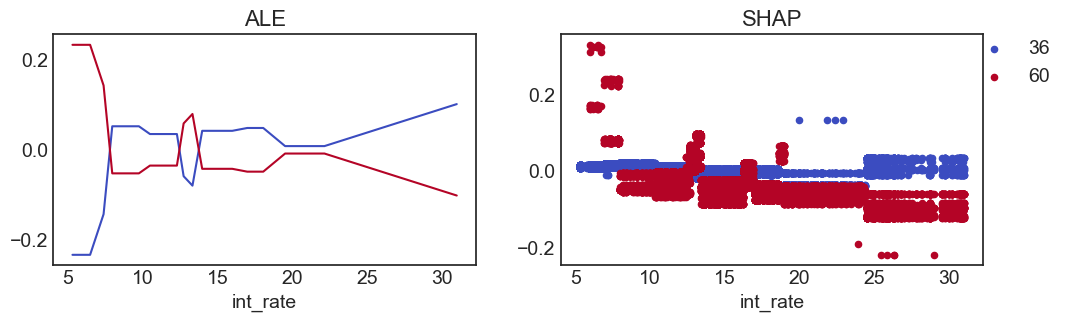

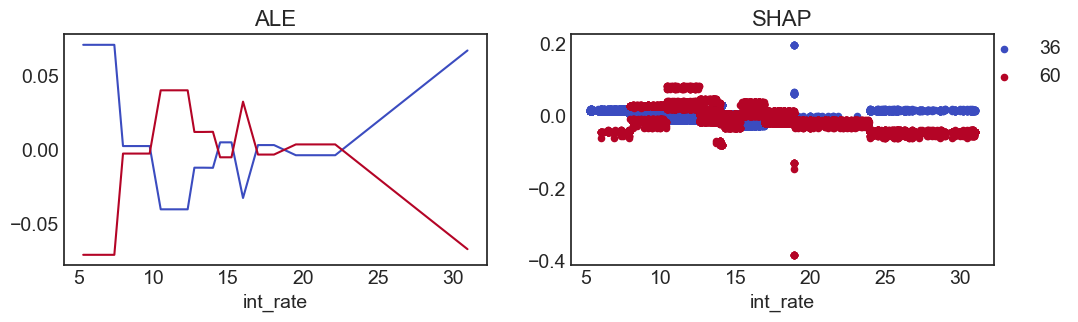

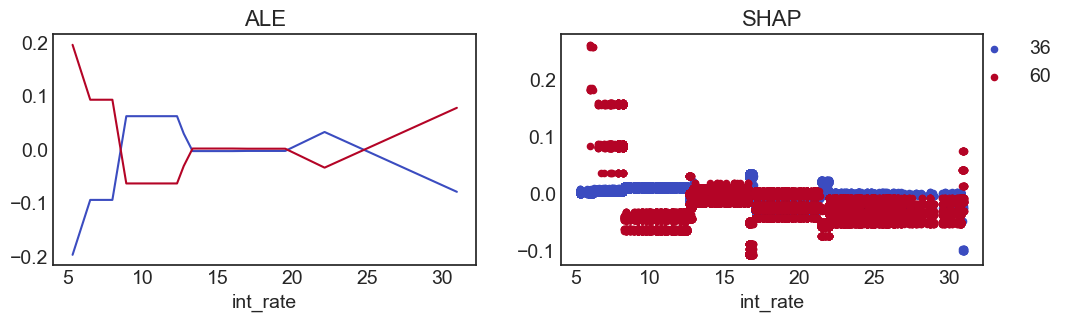

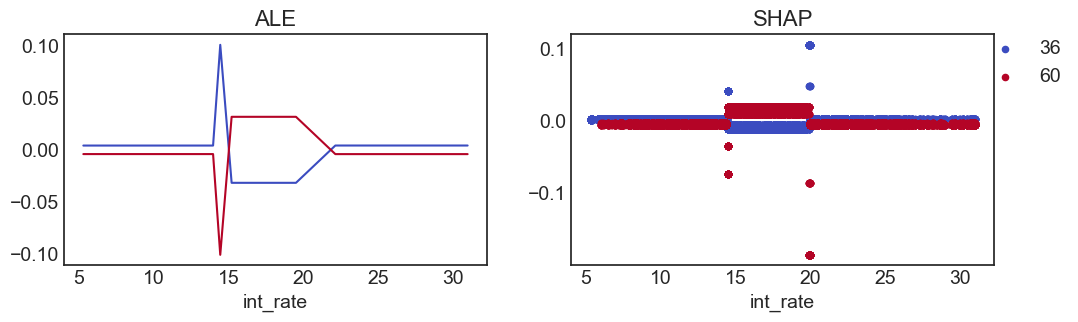

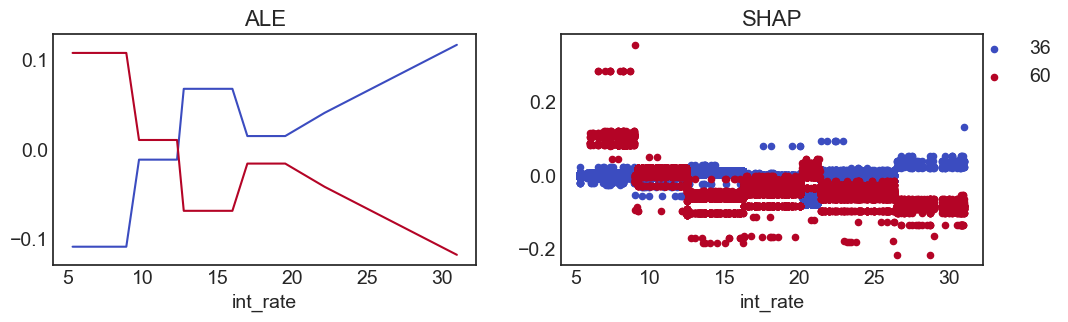

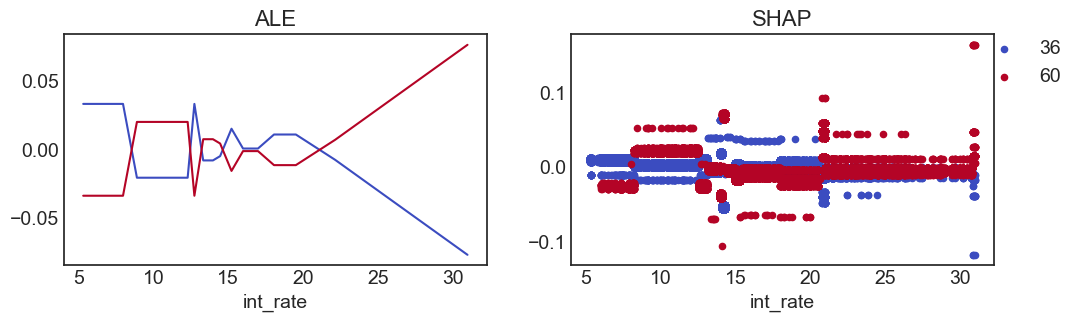

In [242]:
for i in range(0,10):
    
    this_treem = model_8.estimators_[i][0]
    # Get the ALE data
    this_ale = ale(X=train_samp_df[reduced_feature_list_5], model=this_treem, 
                   feature=['int_rate', 'term'], 
                   plot=False)
    
    explainer = shap.TreeExplainer(this_treem, feature_names=reduced_feature_list_5)
    shap_interactions =  explainer.shap_interaction_values(train_samp_df[reduced_feature_list_5])
    
    term_ind = reduced_feature_list_5.index('term')
    int_rate_ind = reduced_feature_list_5.index('int_rate')
    
    this_shap = pd.concat([train_samp_df[['int_rate', 'term']].reset_index(),
                            pd.DataFrame({'shap': shap_interactions[:,term_ind, int_rate_ind]})],
                           axis=1)
    
    print(i)
    comp_plot(this_ale, this_shap)


In [243]:
this_ale.index

Float64Index([ 5.31,  6.49,  7.39,  7.97,   8.9,  9.75, 10.49, 10.99, 11.53,
              12.29, 12.74, 13.33, 13.98, 14.46, 15.22, 15.99, 16.99, 18.06,
              19.52, 22.15, 30.99],
             dtype='float64', name='int_rate')

In [244]:
# 0 [ 5.31,  6.49,  7.39,  7.97,   8.9,  9.75, 10.49, 10.99, 11.53,
              12.29, 12.74, 13.33, 13.98, 14.46, 15.22, 15.99, 16.99, 18.06,
              19.48, 22.15, 30.99]
# 1, 2 same same

IndentationError: unexpected indent (3770174084.py, line 2)

Observations
- first model only one tree had the behavior - tree 6.  It had an anomalous prediction - with low sample count
- second try no tree has behavior but full model does
- third has trees 8 and 9 with the issue - have anomalous leaf pattern but very low rather than high, tree 8 especially, also low sample counts
- fourth has no obvious tree with the issue
- fifth - tree 9 has the issue.  A couple outlier leaves

TO DO
For a tree where the issue happens, try to simplify the decision tree regressor
Import the single tree, reproduce the behavior.   Third batch tree 8 is good choice. Then:
- Try changing the value of the "outlier leaf" and retry
- Try trimming down parts of the tree to get a model with the issue
- Try changing each leaf value and seeing what happens

In [ ]:
model_8.estimators_[i][0].tree_

In [ ]:
model_8.estimators_[8][0].tree_.children_left

In [ ]:
model_8.estimators_[8][0].tree_.threshold